In [1]:
# Supress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Python
import matplotlib.pyplot as plt

# NumPy, PyTorch, sklearn
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

# Custom
from path_loader import PathDataLoader
from networks import SiameseNetworkSimple, SiameseNetworkComplex
from losses import ContrastiveLossSimple, ContrastiveLoss
from patch_generator import PatchGenerator

# Set random seeds
np.random.seed(0)

In [ ]:
"""
def train_siamese_network(train_loader, net, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            input1, input2, label = data
            output1, output2 = net(input1), net(input2)
            loss = criterion(output1, output2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")
"""

In [2]:
def train_siamese_network2(train_loader, net, criterion, optimizer, epochs=10):
    gamma = 1
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            input1, input2 , original1, original2 = data
            output1, output2 = net(input1), net(input2)
            ref1 = input1[:, -1]
            ref2 = input2[:, -1]
            loss = criterion(output1, output2, ref1, ref2, gamma)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")

In [3]:
# Load data
pathLoader = PathDataLoader()
paths = pathLoader.read('eu_city_2x2_macro_306.bin')[:50000]

In [4]:
# Format data
batch_size = 20
train_val_ratio = 0.95

In [ ]:
"""
def generate_pairs(patches, ratio_local, num_pairs = 10000):
    num_patches = len(patches)
    ratio_nonlocal_pair = (1 - ratio_local) / (1 - (1 / num_patches))
    ratio_local_pair = 1 - ratio_nonlocal_pair

    data_pairs = []
    while len(data_pairs) < num_pairs:

      # Pick local pair or non-local pair
      first_patch_index = np.random.randint(num_patches)
      second_patch_index = np.random.randint(num_patches)
      rnd_local = np.random.uniform(0, 1)

      if rnd_local < ratio_local_pair:
        second_patch_index = first_patch_index

      # Pick a random path within a the chosen patch
      rnd_1 = np.random.randint(len(patches[first_patch_index]))
      rnd_2 = np.random.randint(len(patches[second_patch_index]))

      # In case we get same path
      if first_patch_index == second_patch_index:
        while rnd_1 == rnd_2:
          rnd_2 = np.random.randint(len(patches[second_patch_index]))

      if first_patch_index == second_patch_index:
        label = 0
      else:
        label = 1

      data_pairs.append(
      (torch.tensor(patches[first_patch_index][rnd_1], dtype=torch.float), 
      torch.tensor(patches[second_patch_index][rnd_2], dtype=torch.float), 
      torch.tensor(label, dtype=torch.long)))
      
    return data_pairs
    """

In [5]:
def generate_pairs2(patches, patches_feat, ratio_local, num_pairs = 10000):
    num_patches = len(patches)
    ratio_nonlocal_pair = (1 - ratio_local) / (1 - (1 / num_patches))
    ratio_local_pair = 1 - ratio_nonlocal_pair

    data_pairs = []
    while len(data_pairs) < num_pairs:

      # Pick local pair or non-local pair
      first_patch_index = np.random.randint(num_patches)
      second_patch_index = np.random.randint(num_patches)
      rnd_local = np.random.uniform(0, 1)

      if rnd_local < ratio_local_pair:
        second_patch_index = first_patch_index

      # Pick a random path within a the chosen patch
      rnd_1 = np.random.randint(len(patches[first_patch_index]))
      rnd_2 = np.random.randint(len(patches[second_patch_index]))

      # In case we get same path
      if first_patch_index == second_patch_index:
        while rnd_1 == rnd_2:
          rnd_2 = np.random.randint(len(patches[second_patch_index]))


      data_pairs.append(
      (torch.tensor(patches[first_patch_index][rnd_1], dtype=torch.float), 
      torch.tensor(patches[second_patch_index][rnd_2], dtype=torch.float),
      torch.tensor(patches_feat[first_patch_index][rnd_1], dtype=torch.float),
      torch.tensor(patches_feat[second_patch_index][rnd_2], dtype=torch.float)))
      
    return data_pairs


In [6]:
def generate_dataloaders(data_pairs, train_val_ratio, batch_size):
    train_size = int(train_val_ratio * len(data_pairs))
    train_data = data_pairs[:train_size]
    val_data = data_pairs[train_size:]

    dataloaders_train = DataLoader(train_data, batch_size, shuffle=True)
    dataloaders_val = DataLoader(val_data, batch_size, shuffle=True)

    return dataloaders_train, dataloaders_val

In [7]:
def normalize_data(patches):
    num_paths_in_patches = []
    for i in patches:
        num_paths_in_patches.append(len(i))

    # Flatten the list -> Normalize every element
    flattened_patches = [value for patch in patches for path in patch for value in path]
    data_min = min(flattened_patches)
    data_max = max(flattened_patches)
    normalized_patches = [2 * ((x - data_min) / (data_max - data_min)) - 1 for x in flattened_patches]

    # Re-create the 3D list
    patches = [[] for i in range(len(num_paths_in_patches))]
    c = 0
    for i in range(len(num_paths_in_patches)):
        for j in range(num_paths_in_patches[i]):
            patches[i].append([])
            for k in range(21):
                patches[i][j].append(normalized_patches[c])
                c += 1

    return patches

In [9]:
# Generate patches
gen = PatchGenerator(num_patches = 8, attribute="transmitter")
patches = gen.generate_patches(paths)

# Transform PathPropagation objects to feature vectors
patches_feat = gen.transform_patches(patches)

patches_norm = normalize_data(patches_feat)

# Generate pairs
patches_pairs = generate_pairs2(patches_norm, patches_feat, 0.5, 300000)

#Create dataloaders
dataloader_train, dataloader_val = generate_dataloaders(patches_pairs, train_val_ratio, batch_size)

In [10]:
# Instantiate the Siamese Network and Loss Function
net = SiameseNetworkComplex()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

In [11]:
train_siamese_network2(dataloader_train, net, criterion, optimizer, epochs=10)

Epoch 0, Iteration 0, Loss 36.359745025634766
Epoch 0, Iteration 1000, Loss 0.0009366570739075541
Epoch 0, Iteration 2000, Loss 0.00011695238936226815
Epoch 0, Iteration 3000, Loss 0.00025338426348753273
Epoch 0, Iteration 4000, Loss 0.0020240838639438152
Epoch 0, Iteration 5000, Loss 0.0003143766080029309
Epoch 0, Iteration 6000, Loss 0.0030651260167360306
Epoch 0, Iteration 7000, Loss 0.0004088569839950651
Epoch 0, Iteration 8000, Loss 0.00016618460358586162
Epoch 0, Iteration 9000, Loss 8.666298526804894e-05


KeyboardInterrupt: 

In [11]:
# WRITE TO FILES
times = 100

file_original = open('original_data.txt', 'w')
file_embeddings = open('embeddings.txt', 'w')

dataloader_object = iter(dataloader_val)

with open('original_data.txt', 'a') as file:
    with open('embeddings.txt', 'a') as file2:
        for i in range(times):
            data_batch = next(dataloader_object)

            embeddings1 = net(data_batch[0])
            embeddings2 = net(data_batch[1])

            embeddings1_txt = embeddings1.detach().numpy()
            embeddings2_txt = embeddings2.detach().numpy()

            for row in data_batch[2].numpy():
                file.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in data_batch[3].numpy():
                file.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in embeddings1_txt:
                file2.write(' '.join([str(elem) for elem in row]) + '\n')
            for row in embeddings2_txt:
                file2.write(' '.join([str(elem) for elem in row]) + '\n')

file_original.close()
file_embeddings.close()

In [12]:
# Step 1 to visualize embeddings
dataloader_object = iter(dataloader_val)
data_batch = next(dataloader_object)
data_batch2 = next(dataloader_object)
data_batch3 = next(dataloader_object)
data_batch4 = next(dataloader_object)
data_batch5 = next(dataloader_object)

In [13]:
# Step 2 to visualize embeddings
print(data_batch[0][1]) # Change second index to see specific path
print(data_batch[1][1]) 
embeddings = net(data_batch[0])
embeddings2 = net(data_batch[1])
embeddings3 = net(data_batch2[0])
embeddings4 = net(data_batch2[1])
embeddings5 = net(data_batch3[0])
embeddings6 = net(data_batch3[1])
embeddings7 = net(data_batch4[0])
embeddings8 = net(data_batch4[1])
embeddings9 = net(data_batch5[0])
embeddings10 = net(data_batch5[1])
print(embeddings[0]) # Change index to see specific path
print(embeddings2[0])

tensor([-1.3578e-01,  5.3506e-01,  5.4672e-02, -2.0656e-01,  7.3958e-01,
         4.4348e-02, -2.1515e-01,  7.6437e-01,  3.1557e-02, -2.4214e-03,
        -2.4214e-03, -2.4214e-03, -2.4214e-03, -2.4214e-03, -2.4214e-03,
        -2.4214e-03,  5.9726e-04, -1.4152e-03, -2.4214e-03, -2.4214e-03,
        -1.3585e-01])
tensor([-0.0533,  0.3277,  0.0557, -0.0780,  0.3314,  0.0540, -0.1471,  0.3410,
         0.0458, -0.1645,  0.3372,  0.0371, -0.1507,  0.3412,  0.0302, -0.0024,
         0.0006,  0.0006, -0.0004, -0.0014, -0.1427])
tensor([-0.0773, -0.0527, -0.0395,  0.0046, -0.0193, -0.0267, -0.0231],
       grad_fn=<SelectBackward0>)
tensor([-0.0544, -0.0209, -0.0402,  0.0176, -0.0522, -0.0509, -0.0580],
       grad_fn=<SelectBackward0>)


In [14]:
trustworthiness_score = trustworthiness(data_batch3[0], embeddings2.detach().numpy(), n_neighbors=8)
print(trustworthiness_score)

0.5283333333333333


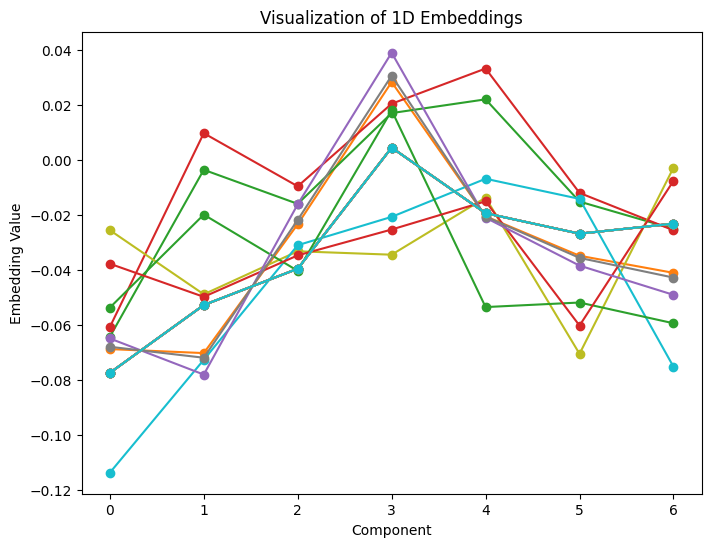

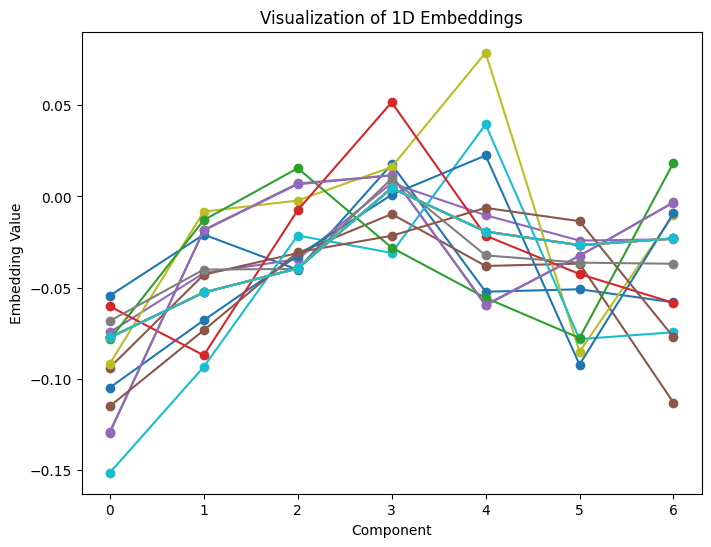

In [15]:
# Step 3 to visualize embeddings

# Convert embeddings to a list
embeddings_list = embeddings.squeeze().tolist()
embeddings_list2 = embeddings2.squeeze().tolist()

# Create x-axis indices
indices = list(range(len(embeddings_list[0])))

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
for i in range(len(embeddings_list)):
    plt.plot(indices, embeddings_list[i], marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
for i in range(len(embeddings_list2)):
    plt.plot(indices, embeddings_list2[i], marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()

t-SNE trustworthiness: 0.8545416666666666


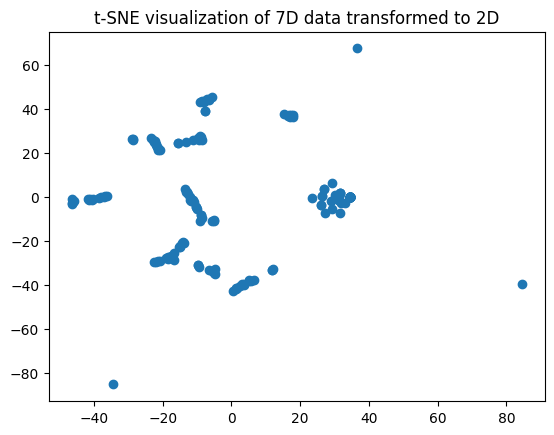

In [20]:
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
embed_concat = torch.cat((embeddings, embeddings2, embeddings3, embeddings4, embeddings5, embeddings6, embeddings7, embeddings8, embeddings9, embeddings10), dim=0).detach().numpy()

X_2d = tsne.fit_transform(embed_concat)
trustworthiness_tsne = trustworthiness(embed_concat, X_2d, n_neighbors=5)
print("t-SNE trustworthiness:", trustworthiness_tsne)

plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.title('t-SNE visualization of 7D data transformed to 2D')
plt.show()